In [176]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report
from sklearn.utils import resample
import time
from alchemy_conn import alchemy_engine

#inherently multiclass:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.svm import LinearSVC
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import RadiusNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

#multiclass as One-vs-One:
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier #set multi_class="one_vs_one"

#multiclass as One-Vs-All:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import Perceptron

import pickle as pickle
from skimage import io
from my_libraries import *
import matplotlib.pyplot as plt
%matplotlib inline

np.random.seed(1000) #to get consistent results every time--used to test hyperparameter
capstone_folder, images_folder = folders()

In [33]:
np.set_printoptions(suppress=True) 

In [2]:
from my_libraries import *
capstone_folder, images_folder = folders()


In [343]:
#read data into df

#use imported alchemy_conn program to generate sqlalchemy connection to summitsdb
engine = alchemy_engine()

#load summits table into pandas df
df = pd.read_sql_query('''SELECT DISTINCT summit_id, name, elevation, isolation, prominence, type, type_str,state 
FROM summits
WHERE type_str IN ('mount', 'mountain', 'peak')
ORDER BY summit_id;''', con=engine)
    # df = pd.read_csv('~/dsi/Capstone/summits.csv')


In [344]:
dfi = pd.read_sql_query("SELECT * FROM images ORDER BY summit_id;", con=engine)

In [345]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8660 entries, 0 to 8659
Data columns (total 8 columns):
summit_id     8660 non-null int64
name          8660 non-null object
elevation     8660 non-null int64
isolation     8660 non-null float64
prominence    8660 non-null int64
type          8660 non-null int64
type_str      8660 non-null object
state         8660 non-null object
dtypes: float64(1), int64(4), object(3)
memory usage: 541.3+ KB


In [346]:
mountain_mask = df.type_str == 'mountain'
mount_mask = df.type_str == 'mount'
peak_mask = df.type_str == 'peak'

df_mountain = df[mountain_mask]
df_mount = df[mount_mask]
df_peak = df[peak_mask]

In [347]:
numrows_in_each_class = 5000

# print("Before resampling: #mount={}, #mountains={}, #peaks={}"
#       .format(df_mount.summit_id.count(), df_mountain.summit_id.count(), df_peak.summit_id.count()))

num_mount_samples = numrows_in_each_class - df_mount.summit_id.count()
num_mountain_samples = numrows_in_each_class - df_mountain.summit_id.count()
num_peak_samples = numrows_in_each_class - df_peak.summit_id.count()

df_mount_upsample = resample(df_mount, replace=True, n_samples=num_mount_samples)
df_mountain_upsample = resample(df_mountain, replace=True, n_samples=num_mountain_samples)
df_peak_upsample = resample(df_peak, replace=True, n_samples=num_peak_samples)

df3 = pd.concat([df_mountain, df_mountain_upsample, df_mount, df_mount_upsample, df_peak, df_peak_upsample]) 

X3 = df3[['elevation','isolation', 'prominence']]
y3 = df3['type']
id3 = df3['summit_id']
name3 = df3['name']
# imageid3 = df3['image_id']

#normalize features data to range 0 - 1
X3_min = X3.min(axis=0) #axis=0 -> up and down columns
X3_max = X3.max(axis=0)
X3 = (X3 - X3_min) / (X3_max - X3_min)
print("len(X3={}, len(y3)={})".format(len(X3), len(y3)))

len(X3=15000, len(y3)=15000)


In [348]:
numrows_in_each_class = 8000

# print("Before resampling: #mountains={}, #peaks={}"
#       .format(df_mountain.summit_id.count(),  df_peak.summit_id.count()))

num_mountain_samples = numrows_in_each_class - df_mountain.summit_id.count()
num_peak_samples = numrows_in_each_class - df_peak.summit_id.count()

df_mountain_upsample = resample(df_mountain, replace=True, n_samples=num_mountain_samples)
df_peak_upsample = resample(df_peak, replace=True, n_samples=num_peak_samples)

df2 = pd.concat([df_mountain, df_mountain_upsample, df_peak, df_peak_upsample]) 

X2 = df2[['elevation','isolation', 'prominence']]
y2 = df2['type']
id2 = df2['summit_id']
name2 = df2['name']

#normalize features data to range 0 - 1
X2_min = X2.min(axis=0) #axis=0 -> up and down columns
X2_max = X2.max(axis=0)
X2 = (X2 - X2_min) / (X2_max - X2_min)

print("len(X2={}, len(y2)={})".format(len(X2), len(y2)))

len(X2=16000, len(y2)=16000)


In [349]:
X3_train, X3_test, y3_train, y3_test = train_test_split(X3, y3, test_size=0.20)
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.20)

In [350]:
X3_train[:5]

,elevation,isolation,prominence
685,0.650502,0.001837,0.035396
5581,0.373718,0.000903,0.043639
5674,0.350167,0.000273,0.033278
3779,0.618861,0.002940,0.043412
525,0.667302,0.005855,0.120557


In [351]:
X3_test[:5]

,elevation,isolation,prominence
666,0.653182,0.000649,0.033278
7771,0.196650,0.000085,0.022765
7450,0.118887,0.002200,0.042505
606,0.659624,0.000594,0.030631
5503,0.399691,0.001146,0.030328


In [352]:
y3_train[:5]

685     1
5581    0
5674    1
3779    0
525     1
Name: type, dtype: int64

In [353]:
y3_test[:5]

666     0
7771    2
7450    1
606     0
5503    2
Name: type, dtype: int64

In [354]:
def pick_best_classifier(X_train, X_test, y_train, y_test):
    '''
    INPUT: four DataFrames
    OUTPUT: fitted model (the one with the best f1 score), DataFrame showing score results for each classifier

    Loops through multiple classifiers, performing GridSearch with cross validation on training data, and prints train and test results (f1, precision, recall, and accuracy scores) for each. The classifier (fitted on the training data) with the best f1 score is returned.
    '''

    # these are the classifiers we are testing:
    names = ['GradientBoostingClassifier', 'LogisticRegression', 'LogisticRegression--liblinear/ovr', 'DecisionTreeClassifier', 'GaussianNB',
             'LinearDiscriminantAnalysis', 'QuadraticDiscriminantAnalysis',
             'LinearSVC', 'MLPClassifier', 'RandomForestClassifier', 'SVC',
             'SGDClassifier', 'Perceptron']

    classifiers = [
        GradientBoostingClassifier(),
        LogisticRegression(random_state=1, max_iter=100),
        LogisticRegression(random_state=1, max_iter=100, multi_class='ovr', solver='liblinear'),
        DecisionTreeClassifier(random_state=1),
        GaussianNB(),
        LinearDiscriminantAnalysis(),
        QuadraticDiscriminantAnalysis(),
        LinearSVC(random_state=1),
        MLPClassifier(),
        RandomForestClassifier(),
        SVC(),
        SGDClassifier(),
        Perceptron()
    ]

    #params for GridSearchCV
    params=[
        {'loss': ['deviance'], 'n_estimators': [50,100,200], 'max_depth': [2,3,5,7],
         'criterion': ['friedman_mse'], 'max_features': [None, 'auto', 'sqrt', 'log2']}, #GradientBoostingClassifier
        {'multi_class': ['ovr', 'multinomial'],
             'solver': ['lbfgs', 'sag', 'saga', 'newton-cg'],
             'class_weight': [None, 'balanced']}, #LogisticRegression

        {'class_weight': [None, 'balanced']}, #LogisticRegression: liblinear/ovr
        {}, #DecisionTreeClassifier
        {}, #GaussianNB
        {'solver': ['svd', 'lsqr', 'eigen']}, #LinearDiscriminantAnalysis
        {}, #QuadraticDiscriminantAnalysis
        {'multi_class': ['ovr', 'crammer_singer'], 'class_weight': [None, 'balanced']}, #LinearSVC
        {}, #MLPClassifier
    #     {}, #RadiusNeighborsClassifier
        {}, #RandomForestClassifier
        {}, #SVC
        {}, #SGDClassifier
        {}  #Perceptron
            ]

    #starting default values
    best_test_score = -999.9
    worst_test_score = 999.9
    best_estimator = ''
    longest_time = -1
    scores = dict()

    #loop through each classifier
    # for i in range(1): #for testing
    print()
    for i in range(len(params)):
        if i > 0: break
        print("=============================== {}. {} ==================================".format(i+1, names[i]))
        score_type = 'accuracy'
        start_time = time.time()

        #GridSearchCV below uses 3 fold cross validation, and searches through parameters in param_grid above for each classifier
        gs = GridSearchCV(estimator=classifiers[i], param_grid=params[i], cv=8, n_jobs=-1, scoring=score_type)
        gs = gs.fit(X_train, y_train)
        seconds = time.time() - start_time
        if seconds > longest_time:
            longest_time = seconds
            longest_time_estimator = names[i]

        #predict results (y_pred) with best_estimator (one with best parameters from GridSearchCV)
        model = gs.best_estimator_
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        #calculate and print scores
        f1 = f1_score(y_test, y_pred, average='weighted')
        precision = precision_score(y_test, y_pred, average='weighted')
        recall = recall_score(y_test, y_pred, average='weighted')
        accuracy = accuracy_score(y_test, y_pred)
        test_score = f1 #f1 used to rank classifiers

        #print results
        print("TEST {} score: {}".format(score_type, test_score))
        print("TRAIN best {} score={}".format(score_type, gs.best_score_))
        if params[i] == {}:
            cur_params = "params: default used"
        else:
            cur_params = "best params: {}".format(gs.best_params_)
        print(cur_params)
        print("#seconds for GridSearchCV for this classifier={}\n".format(seconds))
        print("TEST scores:\nf1: {}\nprecision: {}\nrecall: {}\naccuracy: {}\n".format(f1, precision, recall, accuracy))
        print("\nconfusion matrix:\n    TN    FP\n    FN    TP\n{}\n".format(confusion_matrix(y_test, y_pred)))

        #store scores for printing summary later
        scores[names[i]] = (f1, precision, recall, accuracy)

        #record best and worst results from all classifiers
        if test_score > best_test_score:
            second_best_estimator = best_estimator
            second_best_score = best_test_score
            best_test_score = test_score
            best_estimator = names[i]
            best_params = cur_params
            best_estimator_seconds = seconds
            best_model = model
        if test_score < worst_test_score:
            worst_test_score = test_score
            worst_estimator = names[i]
            worst_params = cur_params
            worst_estimator_seconds = seconds

    #after running each classifer, print summary results
    print()
    print("++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++")
    print("=============================== SUMMARY ==================================")
    print("best_estimator={}\nparams={}\nf1 test score={}\n#seconds={}".format(best_estimator, best_params, best_test_score, best_estimator_seconds))
    print("\nsecond_best_estimator: {}, f1 score: {}".format(second_best_estimator, second_best_score))
    print("\nworst_estimator={}, #seconds={}, params={}, f1 test score={}".format(worst_estimator, worst_estimator_seconds, worst_params, worst_test_score))
    print("\nestimator that took most time: {}, seconds: {}".format(longest_time_estimator, longest_time))

    #print scores summary: rows are each classifer, columns f1, precision, recall, accuracy
    scores = pd.DataFrame(scores).T
    scores.columns = ['f1', 'precision', 'recall', 'accuracy']
    scores = scores.sort_values('f1', ascending=False)
    print("\nSummary of results:\n{}".format(scores))

    print("++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++\n")
    return best_model, scores #returns classifer with best f1 score and best parameters from GridSearchCV


In [355]:
best_model, scores = pick_best_classifier(X2_train, X2_test, y2_train, y2_test)



=============================== 1. GradientBoostingClassifier ==================================
TEST accuracy score: 0.8259335729771456
TRAIN best accuracy score=0.815625
best params: {'criterion': 'friedman_mse', 'loss': 'deviance', 'max_depth': 7, 'max_features': None, 'n_estimators': 200}
#seconds for GridSearchCV for this classifier=24.97015404701233

TEST scores:
f1: 0.8259335729771456
precision: 0.8259375512775433
recall: 0.8259375
accuracy: 0.8259375


confusion matrix:
    TN    FP
    FN    TP
[[1338  275]
 [ 282 1305]]

=============================== 2. LogisticRegression ==================================


KeyboardInterrupt: 

In [ ]:
best_model, scores = pick_best_classifier(X3_train, X3_test, y3_train, y3_test)



=============================== 1. GradientBoostingClassifier ==================================
TEST accuracy score: 0.7569710282704544
TRAIN best accuracy score=0.7581666666666667
best params: {'criterion': 'friedman_mse', 'loss': 'deviance', 'max_depth': 7, 'max_features': 'log2', 'n_estimators': 200}
#seconds for GridSearchCV for this classifier=84.15903401374817

TEST scores:
f1: 0.7569710282704544
precision: 0.7557351879511857
recall: 0.7596666666666667
accuracy: 0.7596666666666667


confusion matrix:
    TN    FP
    FN    TP
[[928  40  26]
 [ 78 663 241]
 [ 67 269 688]]

=============================== 2. LogisticRegression ==================================


In [ ]:
model3 = GradientBoostingClassifier(criterion='friedman_mse', loss='deviance', max_depth=7, max_features='sqrt', n_estimators=200)
model2 = GradientBoostingClassifier(criterion='friedman_mse', loss='deviance', max_depth=7, max_features='sqrt', n_estimators=200)

In [ ]:
model3.fit(X3_train, y3_train)
model2.fit(X2_train, y2_train)

In [20]:
result3 = model3.predict(X3)
result2 = model2.predict(X2)

In [21]:
result3L = []
for r in result3:
    if r == 0:
        result3L.append('mount')
    if r == 1:
        result3L.append('mountain')
    if r == 2:
        result3L.append('peak')
result3L = np.array(result3L)
result3L[:10], result3[:10]

(array(['mountain', 'mountain', 'mountain', 'mountain', 'mountain',
        'mountain', 'mountain', 'mountain', 'mount', 'mountain'],
       dtype='<U8'), array([1, 1, 1, 1, 1, 1, 1, 1, 0, 1]))

In [22]:
result2L = []
for r in result2:
    if r == 0:
        result2L.append('mount')
    if r == 1:
        result2L.append('mountain')
    if r == 2:
        result2L.append('peak')
result2L = np.array(result2L)
result2L[:10], result2[:10]

(array(['mountain', 'mountain', 'mountain', 'mountain', 'mountain',
        'mountain', 'mountain', 'peak', 'peak', 'peak'],
       dtype='<U8'), array([1, 1, 1, 1, 1, 1, 1, 2, 2, 2]))

In [23]:
result2

array([1, 1, 1, ..., 2, 2, 2])

In [ ]:
# with open(capstone_folder + "pickled_images_labels/labels_type_GBC3.pkl", 'wb') as f:
#     pickle.dump(result3L, f, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
# with open(capstone_folder + "pickled_images_labels/labels_type_GBC2.pkl", 'wb') as f:
#     pickle.dump(result2L, f, protocol=pickle.HIGHEST_PROTOCOL)

In [155]:
X2.shape, id2.shape, probs_mtn.shape

((16000, 3), (16000,), (16000,))

In [297]:
probs = model2.predict_proba(X2)
probs

array([[ 0.91371446,  0.08628554],
       [ 0.85910662,  0.14089338],
       [ 0.77256505,  0.22743495],
       ..., 
       [ 0.5164819 ,  0.4835181 ],
       [ 0.03476486,  0.96523514],
       [ 0.16649404,  0.83350596]])

In [298]:
probs = np.column_stack((id2, name2, probs))
probs.shape


(16000, 4)

In [241]:
probs = pd.DataFrame(probs, columns = ['summit_id', 'name', 'mtn_prob', 'peak_prob'])

In [242]:
probs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16000 entries, 0 to 15999
Data columns (total 4 columns):
summit_id    16000 non-null object
name         16000 non-null object
mtn_prob     16000 non-null object
peak_prob    16000 non-null object
dtypes: object(4)
memory usage: 500.1+ KB


In [243]:
probs.describe()

,summit_id,name,mtn_prob,peak_prob
count,16000,16000,16000.000000,16000.000000
unique,4039,3081,4038.000000,4038.000000
top,2308,Sheep Mountain,0.212185,0.657987
freq,11,136,11.000000,11.000000


In [244]:
probs.sort_values('mtn_prob', axis=0, ascending=False)[:25]

,summit_id,name,mtn_prob,peak_prob
6001,16726,Round Mountain,0.993717,0.00628346
7104,16726,Round Mountain,0.993717,0.00628346
7917,16726,Round Mountain,0.993717,0.00628346
1402,16726,Round Mountain,0.993717,0.00628346
2173,54198,Roundtop Mountain,0.992857,0.00714251
2812,54198,Roundtop Mountain,0.992857,0.00714251
2803,54198,Roundtop Mountain,0.992857,0.00714251
2090,53228,Stovepipe Mountain,0.991464,0.008536
2929,53228,Stovepipe Mountain,0.991464,0.008536
7334,53228,Stovepipe Mountain,0.991464,0.008536


In [286]:
dfi[(dfi['summit_id']==54046)]

,summit_id,image_id,url,filename
38415,54046,48634,https://listsofjohn.com/img/49/48634.jpg,48634.jpg


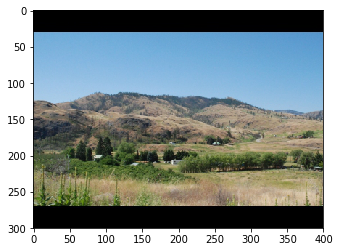

In [327]:
image = io.imread(images_folder + '48634.jpg')
plt.imshow(image);


In [289]:
probs.iloc[3981]

summit_id             54046
name         Pogue Mountain
mtn_prob           0.990625
peak_prob        0.00937527
Name: 3981, dtype: object

In [296]:
probs.sort_values('peak_prob', axis=0, ascending=False)[:25]
#peaks

,summit_id,name,mtn_prob,peak_prob
14722,39,Pikes Peak,0.00408441,0.995916
10660,39,Pikes Peak,0.00408441,0.995916
8013,39,Pikes Peak,0.00408441,0.995916
9765,39,Pikes Peak,0.00408441,0.995916
8000,4,Blanca Peak,0.00409103,0.995909
9728,186832,"Twin Peaks, West",0.0043135,0.995687
12086,186832,"Twin Peaks, West",0.0043135,0.995687
15396,186832,"Twin Peaks, West",0.0043135,0.995687
14166,186832,"Twin Peaks, West",0.0043135,0.995687
15407,162176,"Twin Peaks, South",0.00476377,0.995236


In [323]:
dfi[(dfi['summit_id']==6359)]

,summit_id,image_id,url,filename


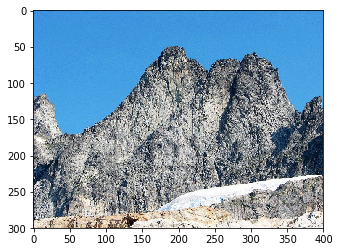

In [326]:
image = io.imread(images_folder + '7430.jpg')
plt.imshow(image)

In [304]:
probs3 = model3.predict_proba(X3)
probs3.shape, X3.shape

((15000, 3), (15000, 3))

In [305]:
probs3 = np.column_stack((id3, name3, probs3))
probs3.shape

(15000, 5)

In [307]:
probs3 = pd.DataFrame(probs3, columns = ['summit_id', 'name', 'mount_prob', 'mtn_prob', 'peak_prob'])

In [308]:
probs3.sort_values('mount_prob', axis=0, ascending=False)[:25]

,summit_id,name,mount_prob,mtn_prob,peak_prob
0,29,Kit Carson Mountain,0.991606,0.00062742,0.00776645
9654,4060,"""Mount Heizer""",0.991606,0.00062742,0.00776645
9642,3852,"Bross, Mount",0.991606,0.00062742,0.00776645
9643,165181,"""Mount Dexter""",0.991606,0.00062742,0.00776645
9644,2,"Massive, Mount",0.991606,0.00062742,0.00776645
9646,55579,"High-G, Mount",0.991606,0.00062742,0.00776645
9647,48801,"Challenger, Mount",0.991606,0.00062742,0.00776645
9648,12245,"Powell, Mount",0.991606,0.00062742,0.00776645
9649,16708,"Timpanogos, Mount",0.991606,0.00062742,0.00776645
9650,18043,"Tomasaki, Mount",0.991606,0.00062742,0.00776645


In [311]:
dfi[(dfi['summit_id']==3852)]

,summit_id,image_id,url,filename
12944,3852,50028,https://listsofjohn.com/img/51/50028.jpg,50028.jpg
12945,3852,8325,https://listsofjohn.com/img/9/8325.jpg,8325.jpg
12946,3852,1357,https://listsofjohn.com/img/2/1357.jpg,1357.jpg
12947,3852,14989,https://listsofjohn.com/img/15/14989.jpg,14989.jpg


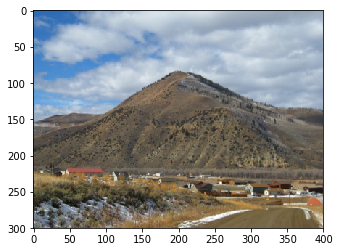

In [316]:
image = io.imread(images_folder + '8325.jpg')
plt.imshow(image)